# End-to-end walkthrough


> A step-by-step guide to using SoilSpecTfm to preprocess spectroscopic data.

**WORK IN PROGRESS**

## Installation

Install `spectfm` and also [SoilSpecData](https://fr.anckalbi.net/soilspecdata/) packages if you want a large spectral Visnir, Mir library to play with.


```bash
pip install -U spectfm soilspecdata
```

In [2]:
#| hide
#| eval: false
import numpy as np
import matplotlib.pyplot as plt
from spectfm.visualization import plot_spectra_comparison

## Data loading

In [2]:
#| eval: false
from soilspecdata.datasets.ossl import get_ossl

In [3]:
#| eval: false
ossl = get_ossl()
mir_data = ossl.get_mir(require_valid=True)

## Baseline corrections

Baseline corrections are essential in spectroscopy for several reasons:

* Physical Effects:
    * Scattering (Mie, Rayleigh, etc.) from particle size differences
    * Sample thickness variations
    * Differences in sample packing density
    * Instrumental drift over time

* These effects create:
    * Vertical shifts in the spectra
    * Multiplicative effects (scaling)
    * Non-linear baseline variations

These unwanted variations can mask the actual chemical information we're interested in. For example, two soil samples with identical chemical composition might produce different spectra just because one sample was packed more densely than the other.



### Standard Normal Variate (SNV)

**Purpose**:

- Corrects both multiplicative and additive scatter effects in spectra
- Works without needing a reference spectrum
- Standardizes each spectrum independently

**When to use**:

- When dealing with powdered/solid samples (like soils)
- When sample preparation varies (thickness, packing)
- When you don't have a good reference spectrum

**How it works**:

- Centers each spectrum (subtracts mean)
- Scales to unit variance (divides by standard deviation)
- Results in comparable spectra regardless of physical variations

**Best practices**:

- Check data quality first (SNV amplifies noise)
- Consider smoothing noisy data before SNV
- Keep original data for reference


In [4]:
#| eval: false
# Import the SNV transform
from spectfm.core import SNV

In [15]:
#| eval: false
X_tfm = SNV().fit_transform(mir_data.spectra)

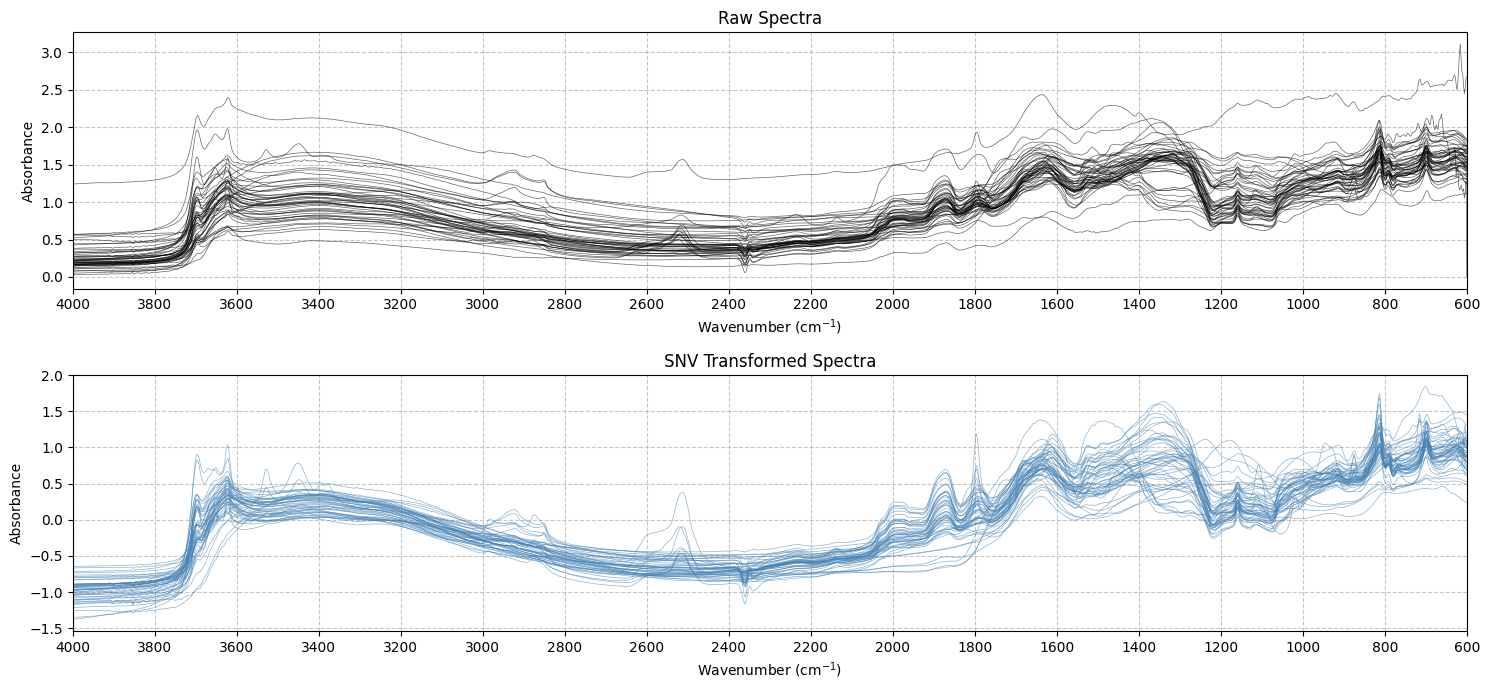

In [14]:
_ = plot_spectra_comparison(
    mir_data.spectra,
    X_tfm,
    mir_data.wavenumbers,
    transformed_title='SNV Transformed Spectra'
)

The **SNV transformation can be customized** by changing its centering and scaling functions. For example, to make the transformation more robust to outliers, you can replace:
- The mean with the median for centering
- The standard deviation with the interquartile range (IQR) for scaling

In [21]:
#| eval: false
# To access the default parameters of the SNV transform, you can use the following:
SNV?

Init signature:
SNV(
    center_func: Callable = <function mean at 0x105b47a30>,
    scale_func: Callable = <function std at 0x105b47c30>,
    eps: float = 1e-10,
)
Docstring:     
Standard Normal Variate transformation with flexible centering and scaling.

Common centering functions:
- np.mean: Standard choice, sensitive to outliers
- np.median: Robust to outliers, slower computation
- np.min: Ensures positive values, sensitive to noise
- lambda x, **kw: 0: No centering, preserves absolute values

Common scaling functions:
- np.std: Standard choice, assumes normal distribution
- lambda x, **kw: np.sqrt(np.mean(x**2, **kw)): RMS, good for baseline variations
- scipy.stats.iqr: Robust to outliers, ignores extreme peaks
- lambda x, **kw: np.max(x, **kw) - np.min(x, **kw): Preserves relative peaks
- lambda x, **kw: np.median(np.abs(x - np.median(x, **kw)), **kw): Most robust, slower
File:           ~/pro/dev/spectfm/spectfm/core.py
Type:           type
Subclasses:     

In [16]:
#| eval: false
from scipy.stats import iqr
X_tfm_alt = SNV(center_func=np.median, scale_func=iqr).fit_transform(mir_data.spectra)

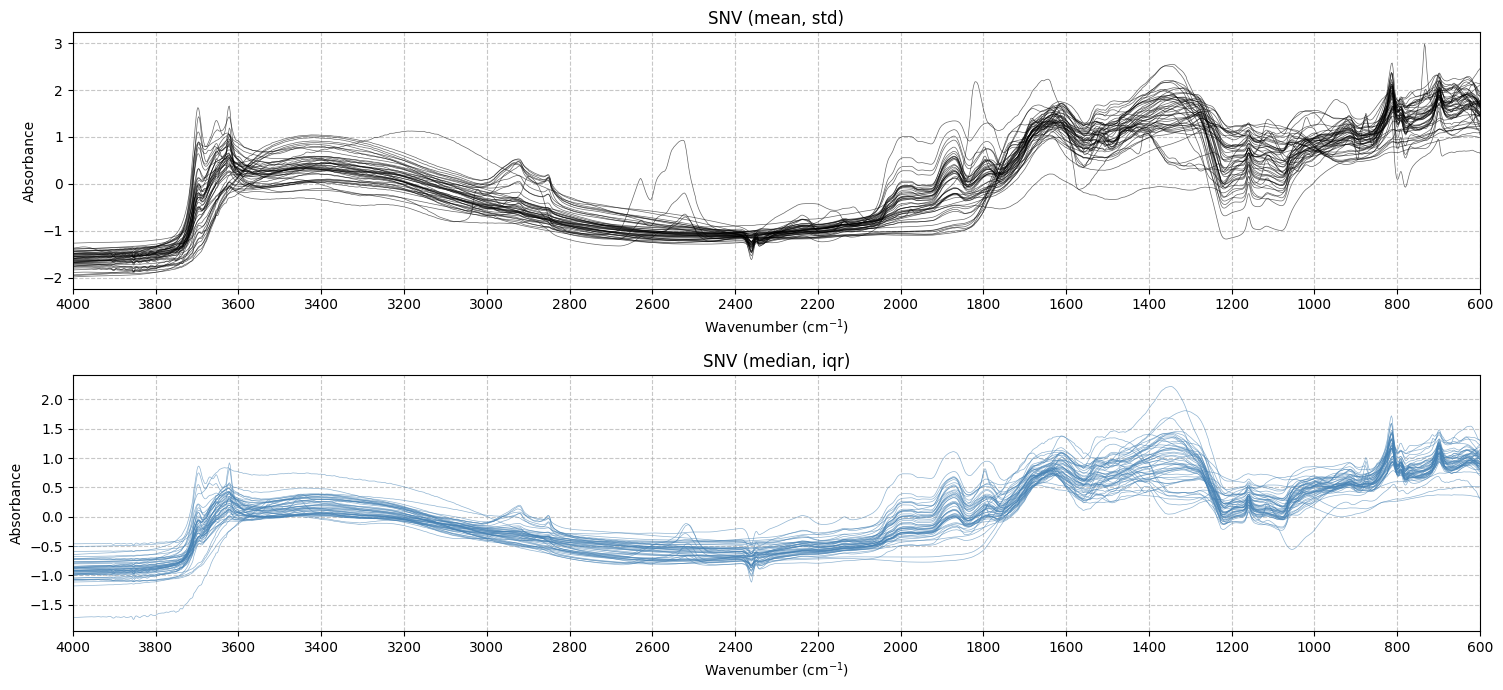

In [17]:
_ = plot_spectra_comparison(
    X_tfm,
    X_tfm_alt,
    mir_data.wavenumbers,
    raw_title='SNV (mean, std)',
    transformed_title='SNV (median, iqr)'
)

In [ ]:
#| eval: false
from spectfm.core import SNV, TakeDerivative, ToAbsorbance
from sklearn.pipeline import Pipeline

### Loading OSSL dataset

In [ ]:
#| eval: false
ossl = get_ossl()
mir_data = ossl.get_mir(require_valid=True)

### Preprocessing pipeline

Implemented transforms developed so far include:

- `SNV`: Standard Normal Variate
- `TakeDerivative`: Take the first derivative of the spectrum
- `ToAbsorbance`: Transform the spectrum to absorbance
- More to come...


Transforms are fully compatible with [scikit-learn](https://scikit-learn.org/stable/) and can be used in a pipeline as follows:

In [ ]:
#| eval: false
pipe = Pipeline([
    ('snv', SNV()), # Standard Normal Variate transformation
    ('deriv', TakeDerivative(window_length=11, polyorder=2, deriv=1)) # First derivative
])

X_tfm = pipe.fit_transform(mir_data.spectra)

### Quick visualization

In [ ]:
#| eval: false
from spectfm.visualization import plot_spectra
from matplotlib import pyplot as plt

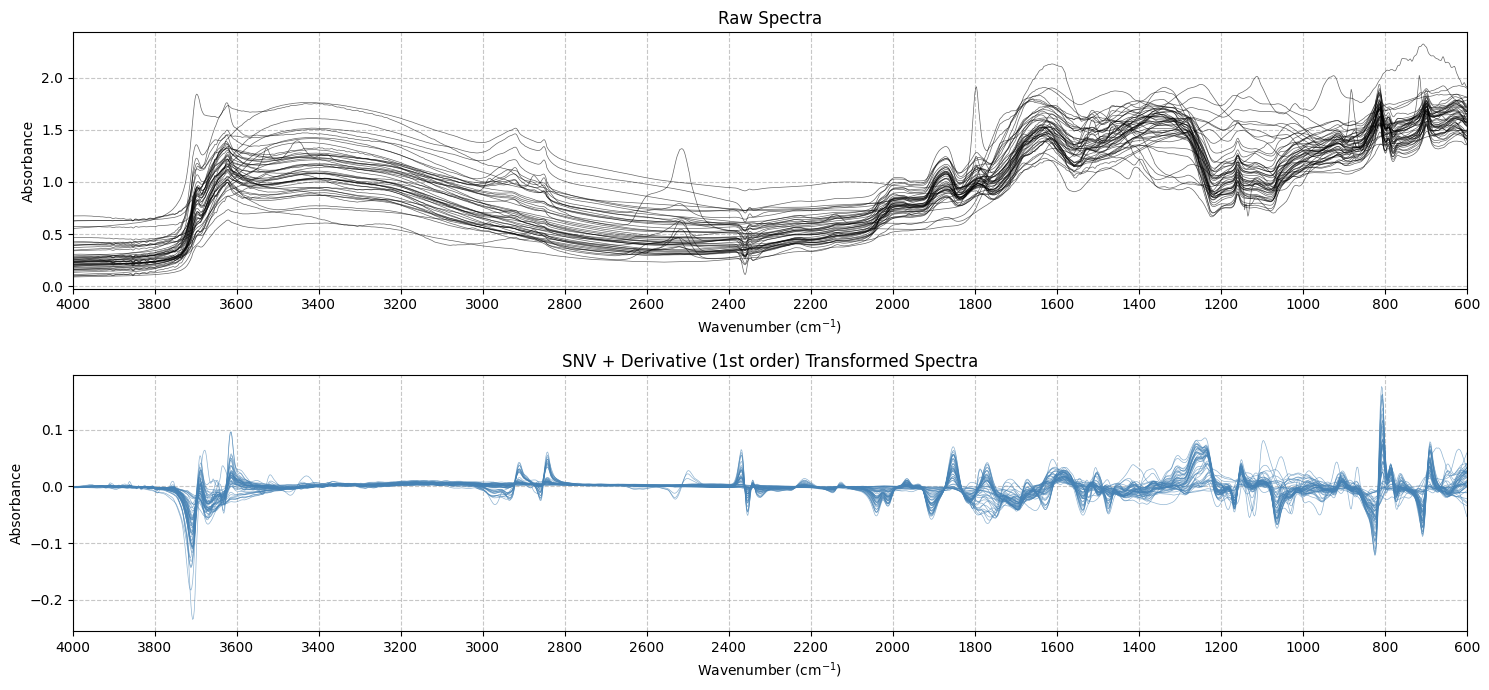

In [ ]:
#| eval: false
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 7))

ax1 = plot_spectra(
    mir_data.spectra, 
    mir_data.wavenumbers,
    ax=ax1,
    ascending=False,
    color='black',
    alpha=0.6,
    lw=0.5,
    xlabel='Wavenumber (cm$^{-1}$)',
    title='Raw Spectra'
)

ax2 = plot_spectra(
    X_tfm,
    mir_data.wavenumbers,
    ax=ax2,
    ascending=False,
    color='steelblue',
    alpha=0.6,
    lw=0.5,
    xlabel='Wavenumber (cm$^{-1}$)',
    title='SNV + Derivative (1st order) Transformed Spectra'
)

plt.tight_layout()

## Dependencies
- fastcore
- numpy
- scipy
- scikit-learn
- matplotlib

## Contributing


### Developer guide

If you are new to using `nbdev` here are some useful pointers to get you started.

Install spectfm in Development mode:

```sh
# make sure spectfm package is installed in development mode
$ pip install -e .

# make changes under nbs/ directory
# ...

# compile to have changes apply to spectfm
$ nbdev_prepare
```

## License

This project is licensed under the Apache2 License - see the LICENSE file for details.

## Support

For questions and support, please [open an issue](https://github.com/franckalbinet/spectfm/issues) on GitHub.
